### In this post I will be discussing about:
**1. Different kinds of non-stationarity in time series data,**<br>
**2. Different tests of checking stationarity,**<br>
**3. Methods to make a time series stationary.**

### Importing Relevant Packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

sns.set()

### Loading and Transforming the Data
Here I will be using tesla stock prices from 2010 to 2020. The Data set can be downloaded from **[here](https://www.kaggle.com/timoboz/tesla-stock-data-from-2010-to-2020)**.

In [2]:
raw_data = pd.read_csv("TSLA.csv") 

In [3]:
raw_data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800


After loading the data, first make a copy, convert the date column into python's datetime stamp and use it as the index.Then set the data frequency to business days. In case new rows are generated, I have filled it with the previous day's value.<br>
These steps have been elaborately explained in my another post: [Processing Time Series Data in Python](https://abhinabasaha.in/2020-04-22-Time_series_Analysis/). 

In [4]:
df = raw_data.copy()
df['Date'] = pd.to_datetime(df['Date'], dayfirst = True)
df.set_index("Date", inplace=True)
df = df.asfreq('b')
df = df.fillna(method='ffill')

In [5]:
df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300.0
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100.0
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800.0


Lets, see how the data looks like..!!

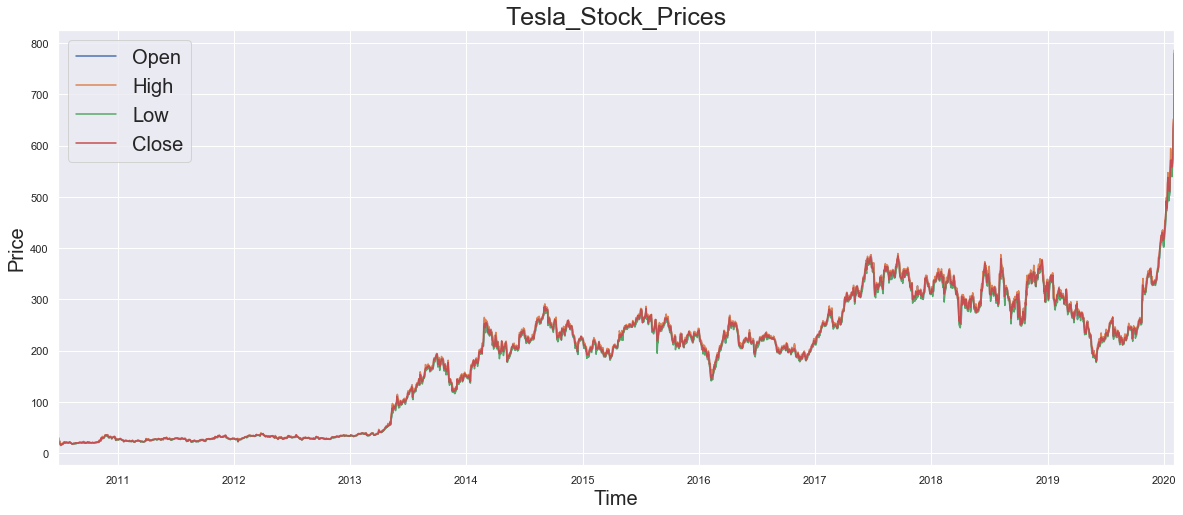

In [6]:
df[['Open','High','Low','Close']].plot(figsize=(20,8))
plt.title('Tesla_Stock_Prices',fontsize=25)
plt.xlabel('Time',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.legend(fontsize = 20, loc=2)
plt.show()

**Now, lets dive into some theoretical concepts, which I will be implementing accordingly.**

## 1.  Different kinds of non-stationarity in time series data

Data in real life, particularly financial data are seldom stationary, the parameters such as mean, variance, co-variances mostly vary with change of time, thus making the time-series non-stationary. Features like **trends**, **cycles**, **random walks** or combinations of the three are common in non-statioanry data. Presence of these behaviours make the non-stationary data unpredictable and thus cannot be modeled or forecasted. Comparing to the non-stationary process whose mean do not remain near, or returns to a long-run mean over time, neither the variance remains fixed, the stationary process oscillates around a constant long-term mean and has a constant time-independent variance. Thus the non-stationary data needs to be transformed into stationary data for predicting its future values. <br>
Before going to the methods of converting non-stationary time series data, its better to analyse different types of the non-stationary time-series which will help in better understanding of the underlying trends which is vital for applying the correct transformation method.<br>
**Examples of non-stationary time series:**<br>

a) **Pure Random Walk** ($Y_t$ = $Y_{t-1}$ + $ε_t$ ): <br>
In random walk, the patterns tend to persist over time and the difference between each period is assumed to be a stochastic (non-systematic) component **white noise** (description of white noise can be found **[here](https://abhinabasaha.in/2020-04-22-Time_series_Analysis/)**). Simply speaking, if $Y_t$ is a value at time 't', then it is equal to the value at time $t-1$, i.e. the last period $Y_{t-1}$ plus a white noise ($ε_t$) which is independent and identically distributed with **mean** ($\mu$=0) and **constant variance** ($\sigma^2$=k).
<br>

b) **Random Walk with Drift** ($Y_t$ = $\alpha$ + $Y_{t-1}$ + $ε_t$ ):<br>
In this case the random walk will have an extra elemnt which is a constant value ($\alpha$), giving it a drift. If $\alpha$ $>$ 0, then $Y_t$ increases on average.
<br>

c) **Deterministic Trend** ($Y_t$ = $\alpha$ + $\beta_t$ + $ε_t$ ):<br> Along with random walk with a drift it has a deterministic trend regressed on a time trend ($\beta_t$). Being non-stationary process it has a mean that grows around a fixed trend, which is constant and independent of time.<br>

d) **Random Walk with Drift and Deterministic Trend** ($Y_t$ = $\alpha$ + $Y_{t-1}$ + $\beta_t$ + $ε_t$ ):<br> Here the non-stationary process is the combination of all the above, i.e. a random walk with a drift component $\alpha$ and a deterministic trend $\beta_t$. 
<br>

In [7]:
df['Open'].describe()

count    2505.000000
mean      186.303058
std       118.878548
min        16.139999
25%        34.349998
50%       212.809998
75%       266.739990
max       673.690002
Name: Open, dtype: float64

**Here I will create different kinds of Non-stationary series.**


In [8]:
np.random.seed(100)

#White Noise
wn = np.random.normal(loc = 0,                    # setting the mean value of the white noise to zero
                      scale = df['Open'].std(),   # setting the standard deviation of the white noise to 
                                                  # that of the Opening price 
                      size = len(df))

#Non-stationary series

rw = []              #Pure Random Walk
rw_drift = []        #Random Walk with drift 
Dtrnd = []           #Deterministic trend
rw_drift_Dtrnd = []  #Random Walk with drift+trend

alpha = 100          #setting the drift value

beta = df['Open'].values  #trend

yt = df['Open'][0]   #Initializing the first value equal to the initial Opening Price

for i in range(len(df)):
    rw.append( yt + 0.1*wn[i])                                # y(t) = y(t-1) + e
    rw_drift.append( alpha + yt + 0.1*wn[i])                  # y(t) = alpha + y(t-1) + e
    Dtrnd.append( alpha + beta[i]  + 0.1*wn[i])               # y(t) = alpha + beta(t) + e
    rw_drift_Dtrnd.append( alpha + beta[i] + yt + 0.1*wn[i])  # y(t) = alpha + beta(t) + y(t-1) + e
    yt = rw[i]

Creating a separate dataframe with opening price and random walk and then plotting it.

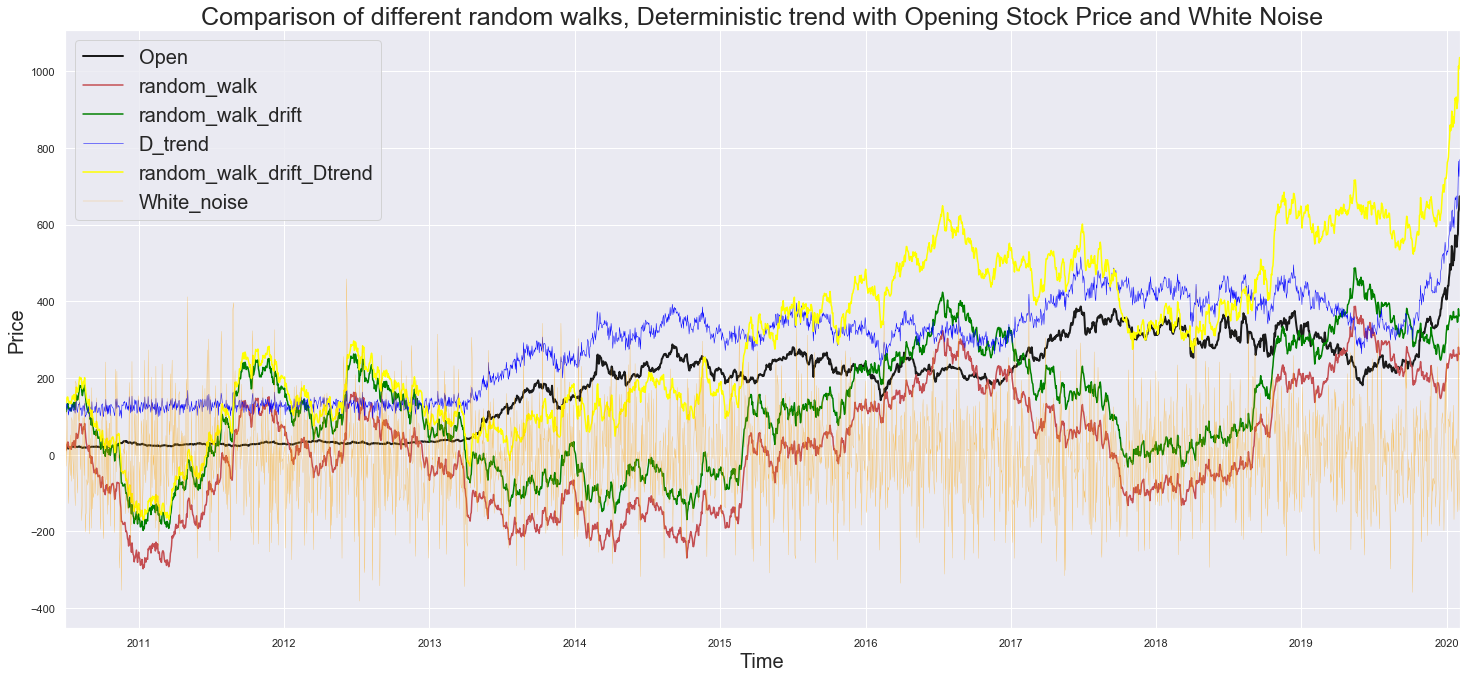

In [9]:
rand_walk = pd.DataFrame(df['Open'])
rand_walk['random_walk'] = rw
rand_walk['random_walk_drift'] = rw_drift
rand_walk['D_trend'] = Dtrnd
rand_walk['random_walk_drift_Dtrend'] = rw_drift_Dtrnd
rand_walk['White_noise'] = wn
fig = plt.figure(figsize=(25,11))

rand_walk['Open'].plot(color = 'k', linewidth=2)
rand_walk['random_walk'].plot(color = 'r')
rand_walk['random_walk_drift'].plot(color = 'green')
rand_walk['D_trend'].plot(color = 'blue', linewidth=0.5)
rand_walk['random_walk_drift_Dtrend'].plot(color = 'yellow')
rand_walk['White_noise'].plot(color = 'orange', linewidth=0.2)

plt.title('Comparison of different random walks, Deterministic trend with Opening Stock Price and White Noise', fontsize=25)
plt.xlabel('Time',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.legend(fontsize = 20)
plt.show()

**Black** = Opening Price, The Original Price Values <br>
**Red** = $Y_t$ + $ε_t$ (White Noise): The random walk having the white noise with zero mean keeps it fluctiating around zero line, without showing any trend.<br>
**Green** = $\alpha$ (Drift) + $Y_t$ + $ε_t$ (White Noise): The Random walk is shifted with a definite drift. <br>
**Blue** = $\beta$ (trend) + $ε_t$ (White Noise): It has got the trend of the original price values, but having a noise component, thus the jumps between periods are unpredictable. <br>
**Yellow** = $\alpha$ (Drift) + $\beta$ (trend) + $Y_t$ + $ε_t$ (White Noise): Combination of all the features. <br> 
**Orange** = $ε_t$ White Noise, the only stationary process.


## 2. Different tests of checking stationarity

#### a) Augmented Dickey–Fuller(ADF) test
In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis($H_0$) that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models. Check [here](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) for more info.  <br>

**Null($H_0$):** Assumes non-stationarity, more precisely it assumes 1 lag auto-correlation co-efficient ($\phi_1$) is lower than 1 ( $\phi_1$ $<$ 1). After computing the test statistics, comparing it with the Dickey-fuller table, if the test statistic is found lower than the critical value, then the null is rejected. So the data comes from a stationary process. 
Simply speaking, **($H_0$) > Critical Value, suggests presence of non-stationarity**. For more information on null-hypothesis, see [here.](https://en.wikipedia.org/wiki/Null_hypothesis)<br>

**Alternative hypothesis ($H_1$):**  ( $\phi_1$ = 1)

<table>
  <tr>
    <th colspan="5">Critical values for Dickey–Fuller t-distribution.<br></th>
  </tr>
  <tr>
    <td></td>
    <td colspan="2">Without trend</td>
    <td colspan="2">With trend<br></td>
  </tr>
  <tr>
    <td>Sample size</td>
    <td>1%</td>
    <td>5%</td>
    <td>1%</td>
    <td>5% </td>
  </tr>
  <tr>
    <td>T = 25</td>
    <td>−3.75</td>
    <td>−3.00</td>
    <td>−4.38</td>
    <td>−3.60 </td>
  </tr>
  <tr>
    <td>T = 50</td>
    <td>−3.58</td>
    <td>−2.93</td>
    <td>−4.15</td>
    <td>−3.50 </td>
  </tr>
  <tr>
    <td>T = 100</td>
    <td>−3.51</td>
    <td>−2.89</td>
    <td>−4.04</td>
    <td>−3.45 </td>
  </tr>
  <tr>
    <td>T = 250</td>
    <td>−3.46</td>
    <td>−2.88</td>
    <td>−3.99</td>
    <td>−3.43 </td>
  </tr>
  <tr>
    <td>T = 500</td>
    <td>−3.44</td>
    <td>−2.87</td>
    <td>−3.98</td>
    <td>−3.42 </td>
  </tr>
  <tr>
    <td>T = ∞</td>
    <td>−3.43</td>
    <td>−2.86</td>
    <td>−3.96</td>
    <td>−3.41</td>
  </tr>
</table>

<br>

It is observed that, presence of a trend further lowers the critical value. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

[refernce](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) 

Lets, try it on the Opening price series.

In [10]:
sts.adfuller(rand_walk['Open'])

(1.0047093977997024,
 0.994315390472365,
 7,
 2497,
 {'1%': -3.4329715599546646,
  '5%': -2.862698190651408,
  '10%': -2.567386549839784},
 16455.995486100284)

**The sts.adfuller() method returns:** <br> 

**adf =** 1.0047093977997024, it is the test statistic.<br>
**pvalue =** 0.994315390472365, the MacKinnon's approximate p-value based on MacKinnon (1994, 2010).<br>
**usedlag =** 7, The number of lags used.<br>
**nobs =** 2497, The number of observations used for the ADF regression and calculation of the critical values.<br>
**critical values =** {'1%': -3.4329715599546646, '5%': -2.862698190651408, '10%': -2.567386549839784}, Critical values for the test statistic at the 1%, 5%, and 10% levels. Based on MacKinnon (2010).<br>
**icbest =** 16455.995486100284, The maximized information criterion if autolag is not None.<br>

Thus the test statistic being more than each of the critical values, it doesn't give much evidence of stationarity. <br>
The pvalue being 0.99 suggests there is roughly 99% chance of not-rejecting the null. That is there is 99$\%$ chance that the data comes from a non-stationary process.<br>
Lag of 7 suggests there is some auto-corelation going back 7 periods. This is critical for selecting appropriate forecasting model.<br>
( Number of observation + Lags ) ususally equals to the length of the series. <br>
Lastly, lower the value of "icbest", its easier to make predictions.



Lets, check for all the series, and compare them with the Dickey-fuller table. Its better to create a dataframe, so that the values can be observed clearly.

In [11]:
dfuller = []
for i in range(6):
    dfuller.append([])
    
dfuller[0] = (sts.adfuller(rand_walk['Open']))[:4]
dfuller[1] = (sts.adfuller(rand_walk['random_walk']))[:4]
dfuller[2] = (sts.adfuller(rand_walk['random_walk_drift']))[:4]
dfuller[3] = (sts.adfuller(rand_walk['D_trend']))[:4]
dfuller[4] = (sts.adfuller(rand_walk['random_walk_drift_Dtrend']))[:4]
dfuller[5] = (sts.adfuller(rand_walk['White_noise']))[:4]

dfuller = pd.DataFrame(dfuller)
dfuller = dfuller.rename(columns={0: 'adf_Test_statistics',1: 'p_value',2: 'usedlag',3: 'n_obs'},
                    index={0: 'Open',1: 'random_walk',2: 'random_walk_drift',
                           3: 'D_trend',4: 'random_walk_drift_Dtrend',5: 'White_noise'})
dfuller

,adf_Test_statistics,p_value,usedlag,n_obs
Open,1.004709,0.994315,7,2497
random_walk,-1.641450,0.461503,0,2504
random_walk_drift,-1.641450,0.461503,0,2504
D_trend,0.781233,0.991327,5,2499
random_walk_drift_Dtrend,0.057244,0.963018,0,2504
White_noise,-50.523496,0.000000,0,2504


**Comparing it with the Dickey-Fuller Table** <br>
Here the test sample is greater than 500, so from the last row of the table it is observed that the test statistics of all the series **(except white noise)** is more than both 1$\%$ and 5$\%$ of the critical values. Thus they are non-stationary process. <br>

The **white noise** being a stationary process, its test statistic is far less than the critical values. The pvalue is also 0 suggesting its stationarity.  Also, as there is no auto-corelation in white noise, lags involved in regression is zero.<br>


### b) KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

Another test for checking stationarity is KPSS test, where the null hypothesis as the process is trend stationary, to an alternate hypothesis of a unit root series. 
<br>
Here, if the test statistics is greater than the critical value, then the null hypothesis is rejected (indicating non-stationarity), which is just opposite to that of the augmented Dickey-Fuller test.
<br>
**Caution:**<br>
A significant disadvantage for the KPSS test is that it has a high rate of Type I errors(i.e. it generally rejects the null hypothesis). On the off chance if attempts are made to control these errors(by having bigger p-values), at that point it negatively impacts the test's capacity. 
<br>
One approach to manage the potential for high Type I errors is to consolidate the KPSS with an ADF test. If the outcome from the two tests proposes stationarity of the time series, then it probably is.

Checking for Opening price:

In [12]:
sts.kpss(rand_walk['Open'],nlags='legacy', regression='c')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(7.698502715310599,
 0.01,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

**Following are the results of the KPSS test:** <br>
Test statistic, p-value, and the critical values at 1%, 2.5%,  5%, and 10% confidence intervals. For Opening price dataset, as, the test statistics is greater than the critical values, the null hypothesis is rejected, thus the process is non-stationary.<br>
Creating a dataframe and comparing with other other series.

In [13]:
kpss_test = []
for i in range(6):
    kpss_test.append([])
    
kpss_test[0] = (sts.kpss(rand_walk['Open'],nlags='legacy', regression='c'))[:3]
kpss_test[1] = (sts.kpss(rand_walk['random_walk'],nlags='legacy', regression='c'))[:3]
kpss_test[2] = (sts.kpss(rand_walk['random_walk_drift'],nlags='legacy', regression='c'))[:3]
kpss_test[3] = (sts.kpss(rand_walk['D_trend'],nlags='legacy', regression='c'))[:3]
kpss_test[4] = (sts.kpss(rand_walk['random_walk_drift_Dtrend'],nlags='legacy', regression='c'))[:3]
kpss_test[5] = (sts.kpss(rand_walk['White_noise'],nlags='legacy', regression='c'))[:3]

kpss_test = pd.DataFrame(kpss_test)
kpss_test = kpss_test.rename(columns={0: 'KPSS_Test_statistics', 1: 'p_value', 2: 'lag'},
                    index={0: 'Open',1: 'random_walk',2: 'random_walk_drift',
                           3: 'D_trend',4: 'random_walk_drift_Dtrend',5: 'White_noise'})
kpss_test

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-va

,KPSS_Test_statistics,p_value,lag
Open,7.698503,0.01,27
random_walk,3.009572,0.01,27
random_walk_drift,3.009572,0.01,27
D_trend,7.695101,0.01,27
random_walk_drift_Dtrend,7.097876,0.01,27
White_noise,0.093809,0.10,27


**Results**: If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, it fail to reject the null hypothesis (series is stationary). For every series **(except white noise)**, the value of the test statistic is greater than the critical values (${ 10\%:0.347, 5\%:0.463, 2.5\%:0.574, 1\%:0.739}$) at all confidence intervals, and hence we can say that the series are not stationary.
<br>
Ii is recommended to perform both the statistical tests (ADF and KPSS) before preparing a model for any time series data. So in summary, the ADF test has an alternate hypothesis of linear or difference stationary, while the KPSS test identifies trend-stationarity in a series.

**Few properties of time series data:**

#### Seasonality
In time series data, seasonality is the presence of variations that occur at specific regular intervals less than a year, such as weekly, monthly, or quarterly. Seasonality may be caused by various factors, such as weather, vacation, and holidays and consists of periodic, repetitive, and generally regular and predictable patterns in the levels of a time series. Seasonality suggests that certain trends will appear on a cyclical basis.<br>
One approach of testing for seasonality, is to decompose the sequence into three effects **trend**, **seasonal** and **residual**. The trend represents the pattern consistent throughout the data, seasonal expresses all cyclical effects due to seasonality and the residuals are the error of prediction.<br>
[reference](https://en.wikipedia.org/wiki/Seasonality) <br>
The simplest type of decomposition is called naive with **naive decomposition**, where it is expected there is a linear relationship between the three parts and the observed time series.<br>
The two main approaches to naive decomposition are : **additive** and **multiplicative**.

**Additive decomposition:** assumes that for any time period the observed value is the sum of the trend seasonal and residual for that period.<br>
**Multiplicative decomposition:** assumes the original series is a product of the trend, seasonal and residual values.

<br>
The stats models package includes a method called seasonal decompose that takes a time series and splits
it up into the three parts.
<br>

Let's start with the **additive approach.**

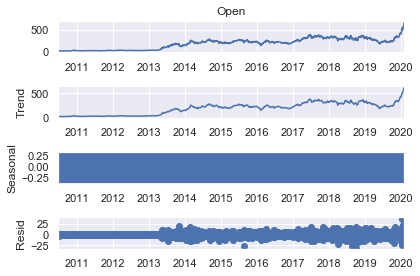

In [14]:
s_dec_additive = seasonal_decompose(rand_walk['Open'], model = "additive")
s_dec_additive.plot()
plt.show()

The results shows the trend resembles the observed series, because the decomposition function uses the previous period values as a trendsetter. 
The seasonal plot looks like a rectangle. This happens when the values are constantly oscillating back and forth and the figure size is too small.
In this case the linear changes results from constantly switching up and down between $-0.25$ and $+0.25$ one for every period. Therefore there is no concrete cyclical pattern determined by using naive decomposition. The residuals are the errors of the model estimates. Essentially they are the difference between true values and predictions for any period.
Overall the results of the additive decomposition suggest no seasonality in the data.

Let's double check this result by computing the **multiplicative decomposition** as well.

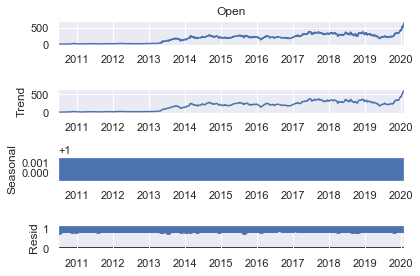

In [15]:
s_dec_multiplicative = seasonal_decompose(rand_walk['Open'], model = "multiplicative")
s_dec_multiplicative.plot()
plt.show()

Here too its shows very similar results to the first decomposition. The seasonal sequence has no clear pattern once again and the trend closely resembles the observed series. Thus it further proves there is no seasonality among Opening prices. Since the trend follows actual data closely, its better to have a closer look at the correlation between past and present values.

#### Autocorrelation
Correlation measures the similarity in the change of values of two series. **Auto-correlation** represents the correlation between a sequence and itself. It measures the level of resemblance between a sequence from several periods ago and the actual data. Such a series is called lagged because it is essentially a delayed version of the original one, for instance it determines how much of yesterday's values resemble today's values.
If the frequency is instead annual, auto correlation will measure the similarities from year to year.

The stats models' graphics package contains a method for plotting the auto correlation function.
A number to the lags argument has to be assigned because the default is the length of the time series.
Here I have analysed with the first 40 lags,which means the last 40 periods before the current one right.
The Zero argument has been set to False,as this argument indicates whether the current period values need to be included in the graph for correlation functions. This is unnecessary because the correlation between a value and itself will always be one.
This will lead to always having the first bar of the graph equal to one which makes the plot more difficult to comprehend correctly. Therefore setting the argument equal to False ensures we only observe a plot for higher lag values as a final step.
Values on the x-axis represent lags.It can noticed how they go up to 40 since that is what I have set the
lags argument equal to. Numbers on the left indicate the possible values for the auto correlation coefficient.
Correlation can only take values between $-1$ and $+1$ which is why the graph stops at 1. The thin line across the plot represents the auto correlation between the time series and a lagged copy of itself.
The first line indicates auto correlation one time period ago, the second line represents the coefficient
value for two periods ago and so on.
The blue area around the x-axis represents the values situated outside are significantly
different from zero which suggests the existence of auto correlation for that specific lag.
A close observation reveals how this area expands. For instance today's prices are usually closer to yesterday's prices than the prices a month ago.
Therefore it should be ensured that the auto correlation coefficient in higher lags is sufficiently greater
to be significantly different from zero.
Also, all the lines are higher than the blue region.
This suggests the coefficients are significant which is an indicator of time dependence in the data.
Moreover it can be seen that auto correlation barely diminishes as the lags increase.
This in turn suggests that prices even a month back can still serve as decent estimates.

**statsmodels.graphics.tsaplots.plot_acf:** Plots the autocorrelation function, plots lags on the horizontal and the correlations on vertical axis.

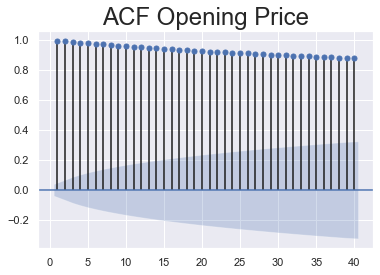

In [16]:
sgt.plot_acf(rand_walk['Open'], lags = 40, zero = False)
plt.title("ACF Opening Price", size = 24)
plt.show()

Let's examine the ACF of the white noise series.
It shoes values going either way.
So there are patterns of positive and negative auto correlation.
This contrasts the ACF for Opening prices where all values were positive, also here all the lines
fall within the blue area.
Thus the coefficients are not significant across the entire plot.
This suggests there is no auto correlation for any lag which is one of the assumptions of White Noise
data.

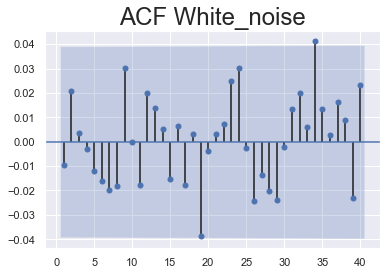

In [17]:
sgt.plot_acf(rand_walk['White_noise'], lags = 40, zero = False)
plt.title("ACF White_noise", size = 24)
plt.show()

#### PACF
To determine only the direct relationship between the time series and its lagged version, then the partial auto correlation needs to be computed.
A function like the ACF called the partial auto correlation function or simply PACF can be used in that case.

Since there are several ways of computing the PACF I am using the medthod: **Order of least squares(OLS).**

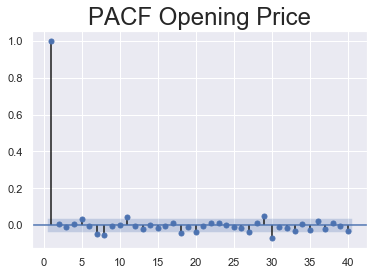

In [18]:
sgt.plot_pacf(rand_walk['Open'], lags = 40, zero = False, method = ('ols'))
plt.title("PACF Opening Price", size = 24)
plt.show()

Let's check out what the PACF plots of random walk and white noise data look like. 

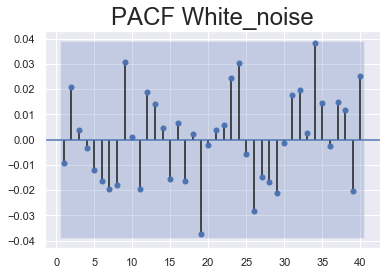

In [19]:
sgt.plot_pacf(rand_walk['White_noise'], lags = 40, zero = False, method = ('ols'))
plt.title("PACF White_noise", size = 24)
plt.show()

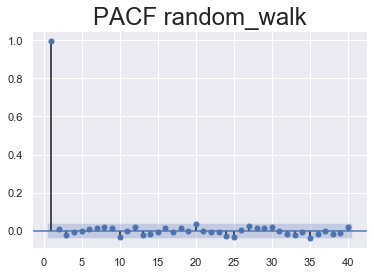

In [20]:
sgt.plot_pacf(rand_walk['random_walk'], lags = 40, zero = False, method = ('ols'))
plt.title("PACF random_walk", size = 24)
plt.show()

There should be no auto correlation between the elements of a white noise sequence.
Thus it is expected the values for all periods to be insignificant to plot the graph.
Most of the values aren't significantly different from zero sum of the coefficients can end up outside
the blue area and seem significant but that is completely random. This aligns with the previous assumption
that there exists no auto correlation in white noise. 

# 3. Methods to make a time series stationary

Now that various concepts of non-stationarity and its different types have been discussed, along with the tools for checking stationarity, and some important properties of time series data let's finally move on to actually making the series stationary as it is necessary in order to use time series forecasting models.

Methods applied are **Differencing**, **Seasonal Differencing** and **Transformation**.

**a) Differencing**

In this method, the difference of consecutive terms in the series is computed. Differencing is typically performed to get rid of the varying mean. Mathematically, differencing can be written as:

$y_t$ = $y_t$ – $y_{t-1}$, where $y_t$ is the value at a time t.

Applying differencing on Opening price and plotting the results:

In [21]:
#code:
new_df =  pd.DataFrame(rand_walk['Open'])
new_df['Differencing'] = list((rand_walk['Open'] - rand_walk['Open'].shift(1).fillna(method='bfill')))


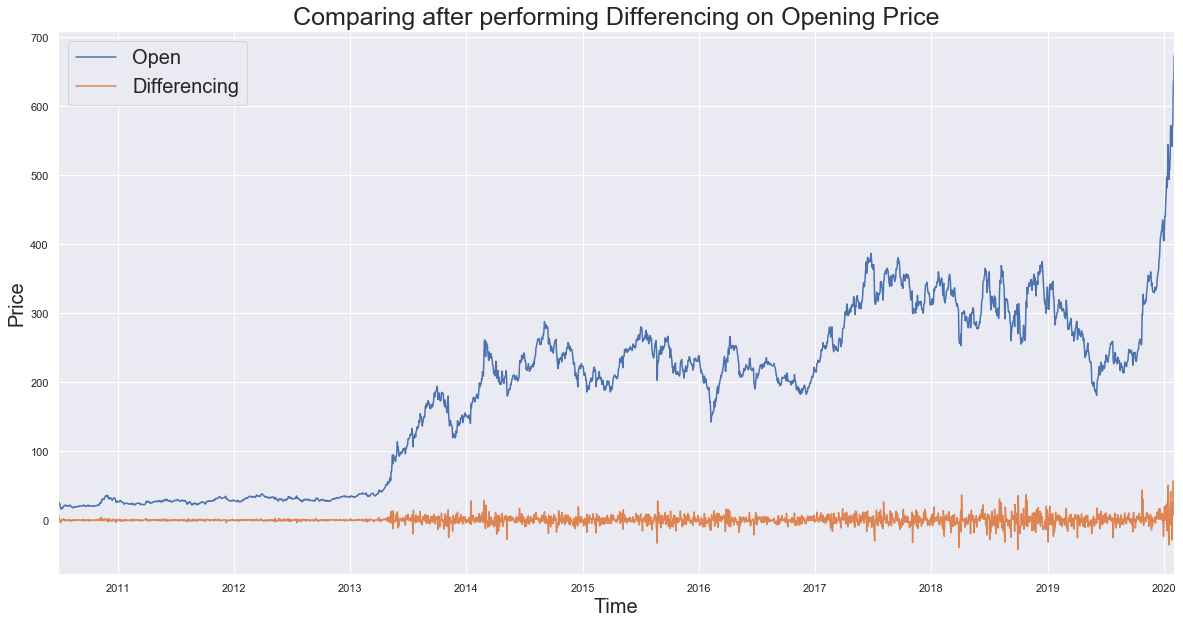

In [22]:
new_df.plot(figsize=(20,10))
plt.title('Comparing after performing Differencing on Opening Price', fontsize=25)
plt.xlabel('Time',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.legend(fontsize = 20, loc=2)
plt.show()

**b) Seasonal Differencing**

In seasonal differencing, instead of calculating the difference between consecutive values, the difference between an observation and a previous observation from the same season is calculated. For example, an observation taken on a Monday will be subtracted from an observation taken on the previous Monday. Mathematically it can be written as:

$y_t$ = $y_t$ – $y_{t-n}$, where n is the time lag.

Here I have used a lag of 30, that is 30 days. 

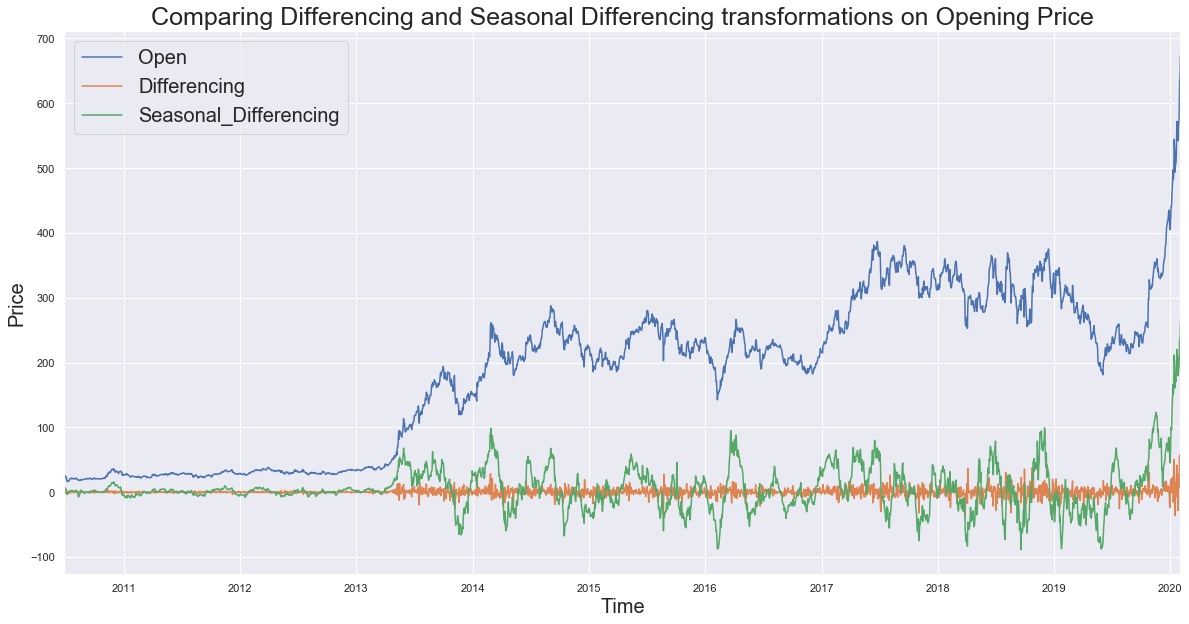

In [23]:
new_df['Seasonal_Differencing'] = list((rand_walk['Open'] - rand_walk['Open'].shift(30).fillna(method='bfill')))
new_df.plot(figsize=(20,10))
plt.title('Comparing Differencing and Seasonal Differencing transformations on Opening Price', fontsize=25)
plt.xlabel('Time',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.legend(fontsize = 20, loc=2)
plt.show()                                   

### Comparing ADF Stats after transforming the Opening Price

In [24]:
compare = []
for i in range(3):
    compare.append([])
    
compare[0] = (sts.adfuller(new_df['Open']))[:4]
compare[1] = (sts.adfuller(new_df['Differencing']))[:4]
compare[2] = (sts.adfuller(new_df['Seasonal_Differencing']))[:4]

compare = pd.DataFrame(compare)
compare = compare.rename(columns={0: 'adf_Test_statistics',1: 'p_value',2: 'usedlag',3: 'n_obs'},
                    index={0: 'Open',1: 'Differencing',2: 'Seasonal_Differencing'})
compare

,adf_Test_statistics,p_value,usedlag,n_obs
Open,1.004709,9.943154e-01,7,2497
Differencing,-16.551949,1.941507e-29,6,2498
Seasonal_Differencing,-6.275149,3.917070e-08,26,2478


**Result:** The test statistics shows the **data has been successfully transformed into a stationary process** as the stats for Differencing and Seasonal Differencing are far less than the critical values, while that of opening price is more. (refer the dickey-fuller table above for critical values)  

**c) Transformation**

Transformations are used to stabilize the non-constant variance of a series. Common transformation methods include **power transform**, **square root**, and **log transform**. <br>

Performing the **log transformations with differencing** on the Opening Price:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


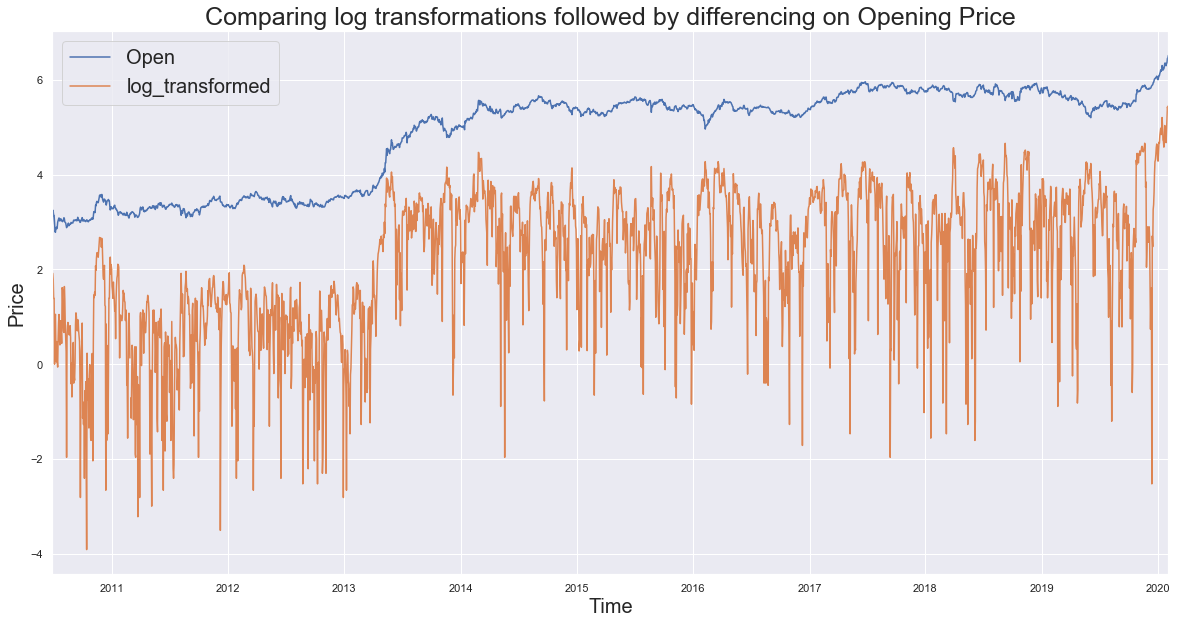

In [25]:
transform_log =  pd.DataFrame(np.log(rand_walk['Open']))
transform_log['log_transformed'] = list(np.log(abs(rand_walk['Open'] - rand_walk['Open'].shift(21).fillna(method='bfill'))))

transform_log.plot(figsize=(20,10))

plt.title('Comparing log transformations followed by differencing on Opening Price', fontsize=25)
plt.xlabel('Time',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.legend(fontsize = 20, loc=2)

plt.show()

The error message comes as the differencing step results to zero for some values, thus after obtaining log it becomes infinite.

In [26]:
transform_log.head(3)

,Open,log_transformed
Date,,
2010-06-29,2.944439,-inf
2010-06-30,3.249987,1.915451
2010-07-01,3.218876,1.791759


#### Checking with square root transformation.

In [27]:
transform_sqrt =  pd.DataFrame(np.sqrt(rand_walk['Open']))

transform_sqrt['sqrt_transformed'] = list(np.sqrt(abs(rand_walk['Open'] - rand_walk['Open'].shift(51).fillna(method='bfill'))))


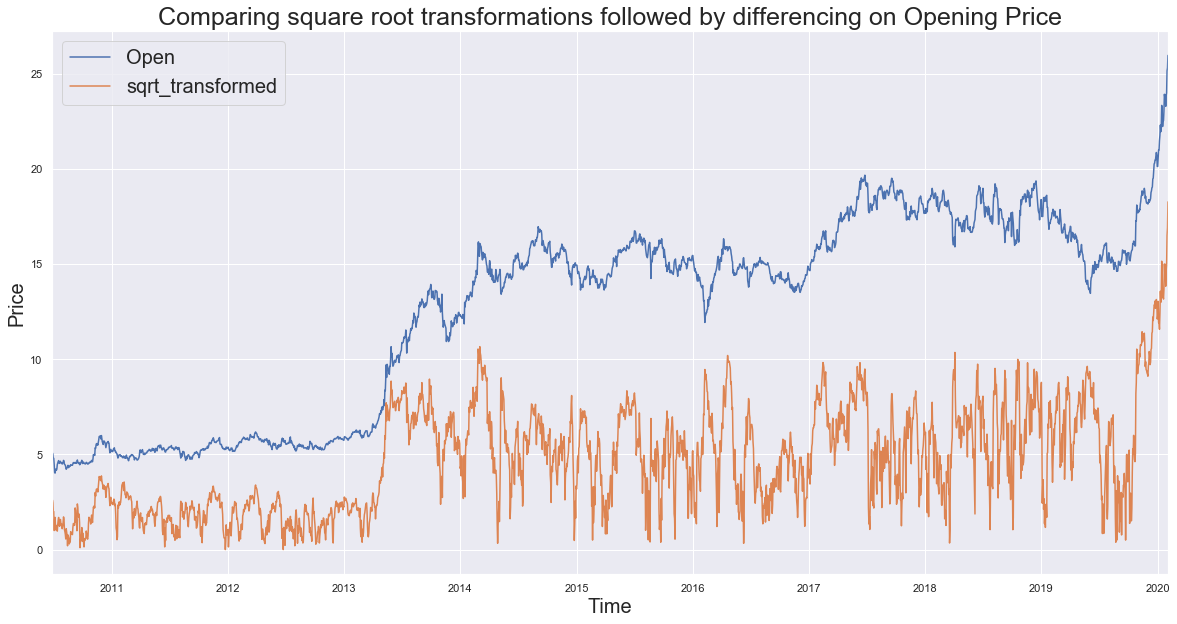

In [28]:
transform_sqrt.plot(figsize=(20,10))

plt.title('Comparing square root transformations followed by differencing on Opening Price', fontsize=25)
plt.xlabel('Time',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.legend(fontsize = 20, loc=2)

plt.show()

### Comparing ADF Stats after transforming the Opening Price

In [29]:
compare1 = []
for i in range(2):
    compare1.append([])
    
compare1[0] = (sts.adfuller(transform_sqrt['Open']))[:4]
compare1[1] = (sts.adfuller(transform_sqrt['sqrt_transformed']))[:4]

compare1 = pd.DataFrame(compare1)
compare1 = compare1.rename(columns={0: 'adf_Test_statistics',1: 'p_value',2: 'usedlag',3: 'n_obs'},
                    index={0: 'Open',1: 'sqrt_transformed'})
compare1

,adf_Test_statistics,p_value,usedlag,n_obs
Open,-0.004424,0.958165,0,2504
sqrt_transformed,-4.482227,0.000212,8,2496


**Result:** The test statistics shows the **data has been successfully transformed into a stationary process** as the stats for square root transformation is less than the critical values, while that of opening price is more. (refer the dickey-fuller table above for critical values)  

**Thanx for reading :)**